<a href="https://colab.research.google.com/github/sarakubik/Computer_Vision_and-Machine_Learning/blob/main/2.3.1%20-%20CNN%20Visualizations/ei_saliency_and_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saliency and Grad-CAM Examples

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/2.3.1%20-%20CNN%20Visualizations/ei_saliency_and_grad_cam.ipynb)

Import a trained model (.zip file) from Edge Impulse and copy in post-processed features of a single sample image. Run the notebook to see a saliency map and Grad-CAM heatmap.

Saliency maps highlight which pixels in the input image were most important (i.e. most salient) in the decision making process.

Grad-CAM looks at the output feature map of the final convolution layer to figure out which areas of the image were the most important in the decision making process.

Author: EdgeImpulse, Inc.<br>
Date: June 19, 2021<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [1]:
import numpy as np

import tensorflow as tf
from keras import activations, layers, models, backend

import cv2

import matplotlib.pyplot as plt

In [3]:
### Unzip model

# Change this based on your .zip model filename
model_zip_path = "/content/ei-electronic_components_cnn-nn-classifier-tensorflow-savedmodel-model.zip"

# Unzip in place
!unzip "{model_zip_path}"

Archive:  /content/ei-electronic_components_cnn-nn-classifier-tensorflow-savedmodel-model.zip
   creating: saved_model/
   creating: saved_model/assets/
   creating: saved_model/variables/
  inflating: saved_model/saved_model.pb  
  inflating: saved_model/variables/variables.index  
  inflating: saved_model/variables/variables.data-00000-of-00001  


In [5]:
### Settings

# Image resolution
width = 28
height = 28

# Labels
labels = ["background", "capacitor", "diode", "led", "resistor"]

# Paste ground processed features from Edge Impulse and set ground-truth label
img = [0.5921, 0.6014, 0.6067, 0.6037, 0.6094, 0.6126, 0.6172, 0.6188, 0.6227, 0.6176, 0.6169, 0.6200, 0.6332, 0.6321, 0.6344, 0.6397, 0.6379, 0.6374, 0.6402, 0.6379, 0.6402, 0.6379, 0.6355, 0.6298, 0.6298, 0.6309, 0.6212, 0.6251, 0.6055, 0.6055, 0.6058, 0.6073, 0.6167, 0.6179, 0.6164, 0.6186, 0.6204, 0.6246, 0.6293, 0.6344, 0.6397, 0.6385, 0.6397, 0.6379, 0.6397, 0.6402, 0.6374, 0.6374, 0.6402, 0.6379, 0.6374, 0.6367, 0.6379, 0.6367, 0.6298, 0.6309, 0.6072, 0.6053, 0.6055, 0.6140, 0.6165, 0.6167, 0.6152, 0.6156, 0.6251, 0.6282, 0.6355, 0.6374, 0.6367, 0.6379, 0.6367, 0.6402, 0.6402, 0.6374, 0.6402, 0.6410, 0.6374, 0.6397, 0.6402, 0.6397, 0.6385, 0.6385, 0.6328, 0.6259, 0.6055, 0.6041, 0.6122, 0.6165, 0.6145, 0.6147, 0.6163, 0.6251, 0.6328, 0.6344, 0.6344, 0.6339, 0.6406, 0.6376, 0.6402, 0.6374, 0.6379, 0.6397, 0.6379, 0.6392, 0.6406, 0.6383, 0.6405, 0.6412, 0.6396, 0.6376, 0.6376, 0.6367, 0.6098, 0.6110, 0.6186, 0.6182, 0.6179, 0.6191, 0.6332, 0.6397, 0.6385, 0.6362, 0.6374, 0.6362, 0.6397, 0.6379, 0.6379, 0.6433, 0.6406, 0.6370, 0.6415, 0.6442, 0.6474, 0.6456, 0.6428, 0.6392, 0.6410, 0.6479, 0.6435, 0.6374, 0.6133, 0.6159, 0.6188, 0.6169, 0.6204, 0.6251, 0.6397, 0.6385, 0.6371, 0.6419, 0.6408, 0.6406, 0.6397, 0.6405, 0.6456, 0.6520, 0.6488, 0.6457, 0.6484, 0.6480, 0.6507, 0.6480, 0.6379, 0.6410, 0.6415, 0.6394, 0.6397, 0.6362, 0.6159, 0.6138, 0.6186, 0.6251, 0.6339, 0.6374, 0.6390, 0.6362, 0.6367, 0.6367, 0.6383, 0.6402, 0.6374, 0.6422, 0.6480, 0.6475, 0.6471, 0.6503, 0.6516, 0.6511, 0.6480, 0.6415, 0.6433, 0.6506, 0.6458, 0.6402, 0.6410, 0.6379, 0.6177, 0.6174, 0.6263, 0.6390, 0.6397, 0.6397, 0.6402, 0.6402, 0.6397, 0.6410, 0.6406, 0.6397, 0.6379, 0.6429, 0.6485, 0.6427, 0.6284, 0.6271, 0.6410, 0.6468, 0.6449, 0.6431, 0.6481, 0.6509, 0.6520, 0.6513, 0.6442, 0.6374, 0.6163, 0.6191, 0.6138, 0.6231, 0.6312, 0.6288, 0.6335, 0.6358, 0.6362, 0.6366, 0.6334, 0.6353, 0.6332, 0.6345, 0.6439, 0.6603, 0.6865, 0.7017, 0.6885, 0.6689, 0.6488, 0.6516, 0.6523, 0.6488, 0.6472, 0.6520, 0.6470, 0.6387, 0.6096, 0.6133, 0.6090, 0.6318, 0.6676, 0.6793, 0.6609, 0.6542, 0.6465, 0.6516, 0.6730, 0.6757, 0.6822, 0.7057, 0.6905, 0.6226, 0.4479, 0.3238, 0.4264, 0.5788, 0.6681, 0.6595, 0.6595, 0.6584, 0.6477, 0.6520, 0.6506, 0.6456, 0.6182, 0.6265, 0.6478, 0.6393, 0.5499, 0.4914, 0.5685, 0.6114, 0.6235, 0.6102, 0.5607, 0.5732, 0.5260, 0.3817, 0.1874, 0.3061, 0.2153, 0.0340, 0.1767, 0.4035, 0.6025, 0.6874, 0.6724, 0.6632, 0.6472, 0.6447, 0.6336, 0.6307, 0.6094, 0.6418, 0.5185, 0.3274, 0.1008, 0.1093, 0.3427, 0.3723, 0.3879, 0.2124, 0.1431, 0.2629, 0.3139, 0.0082, 0.0046, 0.2774, 0.3989, 0.2454, 0.3364, 0.4440, 0.5127, 0.6858, 0.6370, 0.6726, 0.6871, 0.6878, 0.6728, 0.6502, 0.6103, 0.6370, 0.3370, 0.3059, 0.3148, 0.3494, 0.3869, 0.4153, 0.4639, 0.3723, 0.3574, 0.4603, 0.5486, 0.2045, 0.0308, 0.2195, 0.4819, 0.3786, 0.3761, 0.4399, 0.3774, 0.4807, 0.4704, 0.5453, 0.5730, 0.4547, 0.5062, 0.5098, 0.6525, 0.5292, 0.2653, 0.3711, 0.5209, 0.5462, 0.4540, 0.4499, 0.5401, 0.4036, 0.3181, 0.3766, 0.4680, 0.1981, 0.0047, 0.1652, 0.3284, 0.0610, 0.0862, 0.3560, 0.3507, 0.3125, 0.3182, 0.3101, 0.3207, 0.3349, 0.3317, 0.3631, 0.3615, 0.2387, 0.2210, 0.3245, 0.2907, 0.2663, 0.3244, 0.3383, 0.3437, 0.2211, 0.1337, 0.1703, 0.3490, 0.1824, 0.0086, 0.1240, 0.2961, 0.1005, 0.0966, 0.2993, 0.3751, 0.4542, 0.5185, 0.5718, 0.6039, 0.6309, 0.6618, 0.6770, 0.4035, 0.3071, 0.1923, 0.2747, 0.2009, 0.1050, 0.2554, 0.3095, 0.2982, 0.2513, 0.1426, 0.1945, 0.3271, 0.1975, 0.0720, 0.1610, 0.2724, 0.1338, 0.1191, 0.2420, 0.5110, 0.7102, 0.6952, 0.6906, 0.6817, 0.6750, 0.6688, 0.6484, 0.2883, 0.2073, 0.1754, 0.2361, 0.2247, 0.1277, 0.2112, 0.2810, 0.2289, 0.1769, 0.1215, 0.1258, 0.1501, 0.1136, 0.0888, 0.1021, 0.1541, 0.1132, 0.1317, 0.3321, 0.6182, 0.6780, 0.6683, 0.6653, 0.6584, 0.6600, 0.6572, 0.6447, 0.5120, 0.4690, 0.2743, 0.1722, 0.1857, 0.1547, 0.1631, 0.1605, 0.1630, 0.2182, 0.2573, 0.3026, 0.3670, 0.4318, 0.4639, 0.4174, 0.3563, 0.3913, 0.4993, 0.6199, 0.6687, 0.6699, 0.6688, 0.6688, 0.6607, 0.6537, 0.6521, 0.6471, 0.5836, 0.5746, 0.4494, 0.2022, 0.1429, 0.1623, 0.2215, 0.3971, 0.5567, 0.6096, 0.6210, 0.6433, 0.6520, 0.6566, 0.6598, 0.6695, 0.6804, 0.6839, 0.6798, 0.6697, 0.6646, 0.6669, 0.6588, 0.6588, 0.6623, 0.6584, 0.6503, 0.6429, 0.5661, 0.5707, 0.5683, 0.5422, 0.5133, 0.5363, 0.5852, 0.6290, 0.6349, 0.6321, 0.6282, 0.6254, 0.6293, 0.6374, 0.6362, 0.6369, 0.6450, 0.6435, 0.6468, 0.6607, 0.6570, 0.6542, 0.6516, 0.6520, 0.6493, 0.6482, 0.6429, 0.6385, 0.5758, 0.5730, 0.5758, 0.5896, 0.5926, 0.6005, 0.6026, 0.6028, 0.6114, 0.6209, 0.6197, 0.6227, 0.6252, 0.6316, 0.6355, 0.6344, 0.6402, 0.6436, 0.6431, 0.6436, 0.6431, 0.6431, 0.6413, 0.6429, 0.6390, 0.6367, 0.6362, 0.6402, 0.5654, 0.5691, 0.5712, 0.5696, 0.5691, 0.5869, 0.5862, 0.5892, 0.5982, 0.6040, 0.6068, 0.6095, 0.6079, 0.6111, 0.6238, 0.6266, 0.6273, 0.6312, 0.6298, 0.6379, 0.6344, 0.6321, 0.6379, 0.6367, 0.6379, 0.6402, 0.6397, 0.6355, 0.5486, 0.5502, 0.5636, 0.5629, 0.5735, 0.5781, 0.5776, 0.5758, 0.5758, 0.5804, 0.5871, 0.5966, 0.5998, 0.6037, 0.6088, 0.6129, 0.6095, 0.6106, 0.6205, 0.6265, 0.6270, 0.6254, 0.6300, 0.6191, 0.6205, 0.6335, 0.6321, 0.6175, 0.5444, 0.5440, 0.5486, 0.5514, 0.5558, 0.5546, 0.5569, 0.5586, 0.5622, 0.5689, 0.5742, 0.5765, 0.5844, 0.5899, 0.5938, 0.5938, 0.5892, 0.5970, 0.6099, 0.6134, 0.6129, 0.6148, 0.6106, 0.6060, 0.6071, 0.6196, 0.6265, 0.6179, 0.5255, 0.5235, 0.5244, 0.5315, 0.5350, 0.5336, 0.5331, 0.5424, 0.5525, 0.5590, 0.5650, 0.5641, 0.5687, 0.5714, 0.5707, 0.5730, 0.5776, 0.5866, 0.5873, 0.5892, 0.5963, 0.5979, 0.6002, 0.6067, 0.6095, 0.6083, 0.6087, 0.6099, 0.5107, 0.5073, 0.5068, 0.5138, 0.5137, 0.5216, 0.5223, 0.5181, 0.5377, 0.5421, 0.5548, 0.5579, 0.5544, 0.5549, 0.5590, 0.5679, 0.5758, 0.5742, 0.5702, 0.5742, 0.5816, 0.5854, 0.5861, 0.6026, 0.6044, 0.6049, 0.6090, 0.6067, 0.4981, 0.4958, 0.5011, 0.5029, 0.5029, 0.5034, 0.5073, 0.5011, 0.5142, 0.5316, 0.5405, 0.5421, 0.5433, 0.5468, 0.5521, 0.5532, 0.5592, 0.5560, 0.5555, 0.5664, 0.5758, 0.5788, 0.5862, 0.5832, 0.5841, 0.5958, 0.6002, 0.6002, 0.4773, 0.4831, 0.4859, 0.4831, 0.4796, 0.4829, 0.4919, 0.4921, 0.5041, 0.5184, 0.5223, 0.5283, 0.5295, 0.5306, 0.5396, 0.5417, 0.5486, 0.5497, 0.5509, 0.5546, 0.5633, 0.5712, 0.5696, 0.5719, 0.5719, 0.5769, 0.5822, 0.5849]
true_idx = 4  # Resistor

# You probably don't need to change this
model_dir = "/content/saved_model"

In [6]:
### Load model file
model = tf.keras.models.load_model(model_dir)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0

Actual label: resistor


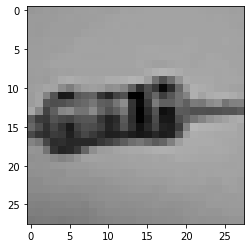

In [7]:
### Reshape image 

# Convert features to 2D Numpy array
img_reshape = np.reshape(np.array(img), (height, width))

# Show the ground-truth label
print("Actual label:", labels[true_idx])

# Display image (make sure we're looking at the right thing)
plt.imshow(img_reshape, cmap='gray', vmin=0.0, vmax=1.0)

In [8]:
### The Keras model expects images in a 4D array with dimensions (sample, height, width, channel)

# Add extra dimension to the image (placeholder for color channels)
img_0 = img_reshape.reshape(img_reshape.shape + (1,))

# Keras expects more than one image (in Numpy array), so convert image(s) to such array
images = np.array([img_0])

# Print dimensions of inference input
print(images.shape)

(1, 28, 28, 1)


In [9]:
### Do a forward pass (inference) with the test image and print the predicted probabilities

# Inference
preds = model.predict(images)

# Print out predictions
for i, pred in enumerate(preds[0]):
  print(labels[i] + ": " + str(pred))

background: 2.0974389e-07
capacitor: 7.067872e-06
diode: 0.19269273
led: 0.0013554605
resistor: 0.80594456


In [10]:
### For either algorithm, we need to remove the Softmax activation function of the last layer
model.layers[-1].activation = None

## Saliency Map

In [11]:
### Based on: https://github.com/keisen/tf-keras-vis/blob/master/tf_keras_vis/saliency.py
def get_saliency_map(img_array, model, class_idx):

  # Gradient calculation requires input to be a tensor
  img_tensor = tf.convert_to_tensor(img_array)

  # Do a forward pass of model with image and track the computations on the "tape"
  with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:

    # Compute (non-softmax) outputs of model with given image
    tape.watch(img_tensor)
    outputs = model(img_tensor, training=False)

    # Get score (predicted value) of actual class
    score = outputs[:, true_idx]

  # Compute gradients of the loss with respect to the input image
  grads = tape.gradient(score, img_tensor)  

  # Finds max value in each color channel of the gradient (should be grayscale for this demo)
  grads_disp = [np.max(g, axis=-1) for g in grads]

  # There should be only one gradient heatmap for this demo
  grad_disp = grads_disp[0]

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  grad_disp = tf.abs(grad_disp)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(grad_disp)
  heatmap_max = np.max(grad_disp)
  heatmap = (grad_disp - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [12]:
### Generate saliency map for the given input image
saliency_map = get_saliency_map(images, model, true_idx)

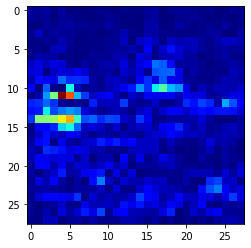

In [13]:
### Draw map
plt.imshow(saliency_map, cmap='jet', vmin=0.0, vmax=1.0)

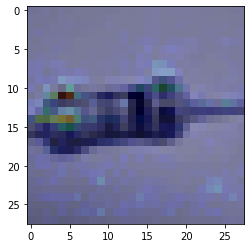

In [14]:
### Overlay the saliency map on top of the original input image
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(saliency_map, cmap='jet', alpha=0.25)

## Grad-CAM

In [15]:
### This function comes from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  heatmap = tf.abs(heatmap)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(heatmap)
  heatmap_max = np.max(heatmap)
  heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [16]:
### We need to tell Grad-CAM where to find the last convolution layer

# Print out the layers in the model
for layer in model.layers:
  print(layer, layer.name)

# Go backwards through the model to find the last convolution layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer.name
        break

# Give a warning if the last convolution layer could not be found
if last_conv_layer is not None:
  print("Last convolution layer found:", last_conv_layer)
else:
  print("ERROR: Last convolution layer could not be found. Do not continue.")

<keras.layers.convolutional.Conv2D object at 0x7f1c4530fdd0> conv2d
<keras.layers.pooling.MaxPooling2D object at 0x7f1c3b1b2ad0> max_pooling2d
<keras.layers.convolutional.Conv2D object at 0x7f1c3797e5d0> conv2d_1
<keras.layers.pooling.MaxPooling2D object at 0x7f1c3797db50> max_pooling2d_1
<keras.layers.core.flatten.Flatten object at 0x7f1c37980810> flatten
<keras.layers.core.dropout.Dropout object at 0x7f1c37980e50> dropout
<keras.layers.core.dense.Dense object at 0x7f1c37988810> y_pred
Last convolution layer found: conv2d_1


In [17]:
### Generate class activation heatmap
heatmap = make_gradcam_heatmap(images, model, last_conv_layer)

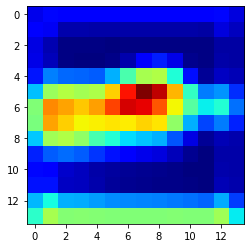

In [18]:
### Draw map
plt.imshow(heatmap, cmap='jet', vmin=0.0, vmax=1.0)

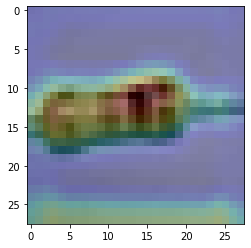

In [19]:
### Overlay the saliency map on top of the original input image

# The heatmap is a lot smaller than the original image, so we upsample it
big_heatmap = cv2.resize(heatmap, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

# Draw original image with heatmap superimposed over it
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(big_heatmap, cmap='jet', alpha=0.25)